In [1]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import wfdb
import random

### Load Data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "/Users/danielkim/Documents/MIDS/W207-ML/Final/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

# One Hot Encoding Meta Data

In [4]:
df = Y[['age', 'sex', 'height', 'weight', 'device']]

In [5]:
df = df.reset_index(drop=True, inplace=False)

In [6]:
meta = df.to_numpy()

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')

In [8]:
enc.fit(meta)

OneHotEncoder(handle_unknown='ignore')

In [9]:
enc.categories_

[array([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0,
        14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0,
        25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0,
        36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0,
        47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0,
        58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0,
        69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0,
        80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 300.0],
       dtype=object),
 array([0, 1], dtype=object),
 array([6.0, 66.0, 67.0, 80.0, 85.0, 90.0, 93.0, 95.0, 97.0, 100.0, 104.0,
        109.0, 116.0, 120.0, 135.0, 136.0, 137.0, 139.0, 140.0, 142.0,
        143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0,
        152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0,
        161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.

In [10]:
meta_enc = enc.transform(meta).toarray()

In [11]:
meta_enc_pad = tf.keras.utils.pad_sequences(
    meta_enc,
    maxlen=1000,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

In [12]:
meta_enc_reshaped = meta_enc_pad[..., np.newaxis]

In [13]:
X = meta_enc_final = np.concatenate((X, meta_enc_reshaped), axis=2)

In [14]:
X[0][13] # First example

array([-0.115, -0.028,  0.086,  0.071, -0.1  ,  0.029, -0.059, -0.011,
        0.018,  0.015,  0.01 , -0.058,  0.   ])

In [15]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True)
classes, counts # Don't end up with same counts each time - fix?

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([1708, 1599, 5468, 9925, 3099]))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [17]:
y_train.shape

(17439,)

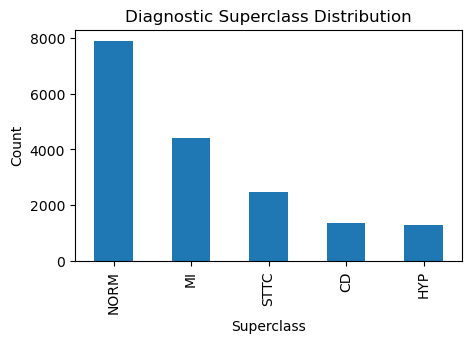

In [18]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

In [19]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts)

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [1365 1280 4422 7907 2465]


### Correct Data Imbalance

In [20]:
smallest_class_count = min(train_counts)
print(smallest_class_count)

1280


In [21]:
def get_class_subset(ekg_class):
    y_train_class_indices = np.where(y_train == ekg_class)[0]
    y_train_class_subset_indices = np.random.choice(
        y_train_class_indices,
        size=smallest_class_count,
        replace=False
    )
    X_train_class_subset = X_train[y_train_class_subset_indices]
    y_train_class_subset = np.array([ekg_class] * smallest_class_count)
    return X_train_class_subset, y_train_class_subset

X_train_cd, y_train_cd = get_class_subset('CD')
X_train_hyp, y_train_hyp = get_class_subset('HYP')
X_train_mi, y_train_mi = get_class_subset('MI')
X_train_norm, y_train_norm = get_class_subset('NORM')
X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [22]:
print(X_train_cd.shape)
#print(X_train_hyp.shape)
#print(X_train_mi.shape)
#print(X_train_norm.shape)
#print(X_train_sttc.shape)

(1280, 1000, 13)


In [23]:
X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
X_train.shape

(6400, 1000, 13)

In [24]:
#print(y_train_cd.shape)
#print(y_train_hyp.shape)
#print(y_train_mi.shape)
#print(y_train_norm.shape)
#print(y_train_sttc.shape)

In [25]:
y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
y_train.shape

(6400,)

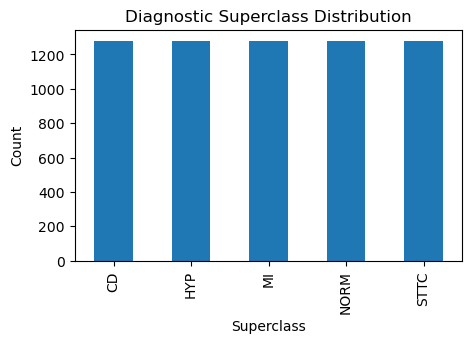

In [26]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

### Split Data

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [28]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (5120, 1000, 13)
Training labels shape: (5120,) 

Validation data shape: (1280, 1000, 13)
Validation labels shape: (1280,) 

Test data shape: (4360, 1000, 13)
Test labels shape: (4360,)


### Normalize Data

In [29]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-16.32 17.212


In [30]:
#def normalize(data):
#    data_mean = data.mean()
#    data_sd = data.std()
#    return (data - data_mean) / data_sd

#X_train = normalize(X_train)
#X_val = normalize(X_val)
#X_test = normalize(X_test)

In [31]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-16.32 17.212


### Baseline Models

Training accuracy: 0.2046875
Validation accuracy: 0.18671875
Test accuracy: 0.19541284403669726


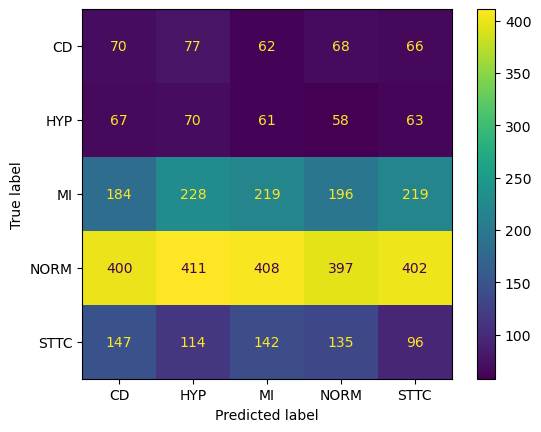

In [32]:
def random_classification(training_data):
    return [np.random.choice(classes) for _ in training_data]

predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.201953125
Validation accuracy: 0.1921875
Test accuracy: 0.4628440366972477


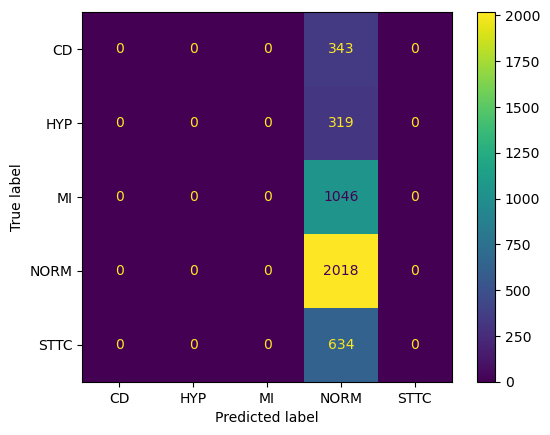

In [33]:
def always_classify_normal(training_data):
    return ['NORM'] * len(training_data)

predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [34]:
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(5120, 13000)
(1280, 13000)
(4360, 13000)


**Neural Network**

In [35]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [90]:

#set tunable parameters for a model for Keras tuner
def build_model_hp(hp):
    inputs = keras.Input(shape=(1000, 13))

    x = inputs
    
    for i in range(hp.Int("cnn_layers", 4, 5)):
        x = layers.Conv1D(
            hp.Int(f"filters_{i}", 64, 256, step=32),
            kernel_size= 3,
            activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]),
        )(x)
        x = layers.MaxPooling1D(
            pool_size= 2
        )(x)
    x = layers.Flatten()(x)
    
    for i in range(hp.Int("dropout_layers", 2, 8)):
        x = layers.Dropout(0.5)(x)
    
    for i in range(hp.Int("dense_layers", 2, 8)):
        x = layers.Dense(32, activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]))(x)

    # The last layer contains 12 units,
    # which is the same as the number of classes.
    outputs = layers.Dense(units=12, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(
        loss=hp.Choice("loss", ['categorical_crossentropy', 'binary_crossentropy']),
        metrics=["categorical_accuracy"],
        optimizer=hp.Choice("optimizer", ["adam", "sgd"]),
    )
    
    return model

In [100]:
# Initialize hp's and build a model
hp = kt.HyperParameters()
model = build_model_hp(hp)
#Test if model works
model(X_train[:100])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 13)]        0         
                                                                 
 conv1d_4 (Conv1D)           (None, 998, 64)           2560      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 499, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 497, 64)           12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 248, 64)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 246, 64)           1235

In [92]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [93]:
rm -rf ./logs/

In [96]:
tuner = kt.RandomSearch(
    build_model_hp,
    max_trials=50,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_categorical_accuracy",
    # Set a directory to store the intermediate results.
    directory=path,
)

In [97]:
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    # Use the TensorBoard callback.
    callbacks=[keras.callbacks.TensorBoard(path +"logs")],
)
models = tuner.get_best_models(num_models = 5)

Trial 50 Complete [00h 01m 14s]
val_categorical_accuracy: 0.4085937440395355

Best val_categorical_accuracy So Far: 0.4671874940395355
Total elapsed time: 02h 07m 02s


In [98]:
best_model = models[0]
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 13)]        0         
                                                                 
 conv1d (Conv1D)             (None, 998, 224)          8960      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 224)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 224)          150752    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 224)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 256)          172288

In [99]:
%tensorboard --logdir=/Users/danielkim/Documents/MIDS/W207-ML/Final/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/logs --port=6060

In [103]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

137/137 [==============================] - 6s 43ms/step - loss: 0.4583 - categorical_accuracy: 0.5041
Test loss: 0.4583238661289215, Test accuracy: 0.5041284561157227


In [131]:
y_pred = best_model.predict(X_test)
y_true = y_test

137/137 [==============================] - 3s 24ms/step


In [157]:
threshold = 1/12

recall = keras.metrics.Recall(thresholds=threshold)
recall.update_state(y_true, y_pred)
recall = recall.result().numpy()


precision = keras.metrics.Precision(thresholds=threshold)
precision.update_state(y_true, y_pred)
precision = precision.result().numpy()


f1_score = 2 * (precision * recall) / (precision + recall)
print( f" F1: {f1_score} Precision: {precision} Recall: {recall}")

 F1: 0.5878081476333429 Precision: 0.5052184462547302 Recall: 0.7026770710945129
